In [1]:
# https://github.com/MhLiao/DB
# https://github.com/zonasw/DBNet
# https://github.com/WenmuZhou/DBNet.pytorch
# https://github.com/xuannianz/DifferentiableBinarization
import sys
import tensorflow as tf
sys.path.append('..')
tf.get_logger().setLevel('ERROR')

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    device_name = tf.test.gpu_device_name()
    print('Found GPU at:', device_name)
    !nvcc -V
else: print('Using CPU')

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


# Hyperparameters

In [3]:
IGNORE_TEXTS = ['###']
IMAGE_SIZE = 640 # Must be divisible by 32
THRESH_MIN = 0.3
THRESH_MAX = 0.7
SHRINK_RATIO = 0.4

MIN_BOX_SCORE = 0.5
MAX_CANDIDATES = 1000
IMAGE_SHORT_SIDE = 736 # Must be divisible by 32
AREA_PRECISION_CONSTRAINT = 0.4
AREA_RECALL_CONSTRAINT = 0.4

In [4]:
TRAIN_PATHS_MAP = './datasets/train.txt'
VALIDATE_PATHS_MAP = './datasets/validate.txt'
TRAIN_BATCH_SIZE = 8
VALIDATE_BATCH_SIZE = 1
LEARNING_RATE = 1e-3
EPOCHS = 50

# Load the data

In [5]:
from tfdbnet.loader import AnnotationsImporter, DataGenerator
train_annotations = AnnotationsImporter(TRAIN_PATHS_MAP)
validate_annotations = AnnotationsImporter(VALIDATE_PATHS_MAP)

[GET] Loading from ./datasets/train.txt: 1000 images
[GET] Loading from ./datasets/validate.txt: 500 images


In [6]:
print(
    f'Number of images found:'
    f' {train_annotations.images_count} + {validate_annotations.images_count} ='
    f' {train_annotations.images_count + validate_annotations.images_count}\n'
    f'Number of bounding boxes in all images:'
    f' {train_annotations.all_boxes_count} + {validate_annotations.all_boxes_count} ='
    f' {train_annotations.all_boxes_count + validate_annotations.all_boxes_count}'
)

Number of images found: 1000 + 500 = 1500
Number of bounding boxes in all images: 11886 + 5230 = 17116


In [7]:
train_generator = DataGenerator(
    train_annotations.annotations, 
    TRAIN_BATCH_SIZE, IMAGE_SIZE, IGNORE_TEXTS,  
    THRESH_MIN, THRESH_MAX, SHRINK_RATIO, seed=2022
)
validate_generator = DataGenerator(
    validate_annotations.annotations, 
    VALIDATE_BATCH_SIZE, IMAGE_SIZE, IGNORE_TEXTS, 
    THRESH_MIN, THRESH_MAX, SHRINK_RATIO, seed=None # No shuffle
)

# Build and compile the model

In [8]:
from tfdbnet.model import DBNet
from tfdbnet.processor import PostProcessor
post_processor = PostProcessor(min_box_score=MIN_BOX_SCORE, max_candidates=MAX_CANDIDATES)
dbnet = DBNet(post_processor, backbone='ResNet18', k=50)

In [9]:
from tensorflow.keras.optimizers import Adam
from tfdbnet.losses import DBLoss
dbnet.compile(
    optimizer = Adam(learning_rate=LEARNING_RATE, amsgrad=True), 
    loss = DBLoss(alpha=5.0, beta=10.0, negative_ratio=3.0)
)
dbnet.model.summary(line_length=120)

Model: "DBNet"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 image (InputLayer)                    [(None, None, None, 3)]    0             []                                      
                                                                                                                        
 conv1 (Conv2D)                        (None, None, None, 64)     9408          ['image[0][0]']                         
                                                                                                                        
 bn_conv1 (BatchNormalization)         (None, None, None, 64)     256           ['conv1[0][0]']                         
                                                                                                                        
 conv1_relu (Acti

                                                                                                                        
 bn3a_branch2b (BatchNormalization)    (None, None, None, 128)    512           ['res3a_branch2b[0][0]']                
                                                                                                                        
 bn3a_branch1 (BatchNormalization)     (None, None, None, 128)    512           ['res3a_branch1[0][0]']                 
                                                                                                                        
 res3a (Add)                           (None, None, None, 128)    0             ['bn3a_branch2b[0][0]',                 
                                                                                 'bn3a_branch1[0][0]']                  
                                                                                                                        
 res3a_relu (Activation)        

                                                                                                                        
 res4b1_relu (Activation)              (None, None, None, 256)    0             ['res4b1[0][0]']                        
                                                                                                                        
 padding5a_branch2a (ZeroPadding2D)    (None, None, None, 256)    0             ['res4b1_relu[0][0]']                   
                                                                                                                        
 res5a_branch2a (Conv2D)               (None, None, None, 512)    1179648       ['padding5a_branch2a[0][0]']            
                                                                                                                        
 bn5a_branch2a (BatchNormalization)    (None, None, None, 512)    2048          ['res5a_branch2a[0][0]']                
                                

 P2 (ConvBnRelu)                       (None, None, None, 64)     147776        ['tf.__operators__.add_2[0][0]']        
                                                                                                                        
 P3 (Sequential)                       (None, None, None, 64)     147776        ['tf.__operators__.add_1[0][0]']        
                                                                                                                        
 P4 (Sequential)                       (None, None, None, 64)     147776        ['tf.__operators__.add[0][0]']          
                                                                                                                        
 P5 (Sequential)                       (None, None, None, 64)     147776        ['in5[0][0]']                           
                                                                                                                        
 fuse (Concatenate)             

# Callbacks

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
from tfdbnet.metrics import TedEvalMetric
from tqdm.notebook import tqdm

# Stop if no improvement after 10 epochs
early_stopping_callback = EarlyStopping(patience=10, restore_best_weights=True, verbose=1)

# Calculate TedEvalMetric after 10 epochs
tedeval_callback = TedEvalMetric(
    true_annotations = validate_annotations.annotations, 
    ignore_texts = IGNORE_TEXTS, 
    min_box_score = MIN_BOX_SCORE,
    image_short_side = IMAGE_SHORT_SIDE,
    area_precision_constraint = AREA_PRECISION_CONSTRAINT,
    area_recall_constraint = AREA_RECALL_CONSTRAINT,
    progressbar = tqdm,
    eval_best_weights = True, # Restore the best model and evaluate it on train end 
    eval_steps = 10,
)

Reading evaluation images:   0%|          | 0/500 [00:00<?, ?image/s]

# Training

In [11]:
%%time
history = dbnet.fit(
    train_generator,
    validation_data = validate_generator,
    validation_steps = len(validate_generator),
    steps_per_epoch = len(train_generator),
    epochs = EPOCHS,
    callbacks = [early_stopping_callback, tedeval_callback],
    verbose = 1
).history
dbnet.model.save_weights('dbnet.h5')

Epoch 1/50
125/125 [==============================] - 65s 453ms/step - loss: 5.4202 - val_loss: 19.2997
Epoch 2/50
125/125 [==============================] - 56s 447ms/step - loss: 4.6432 - val_loss: 5.0952
Epoch 3/50
125/125 [==============================] - 56s 446ms/step - loss: 4.4101 - val_loss: 4.9888
Epoch 4/50
125/125 [==============================] - 56s 448ms/step - loss: 4.2459 - val_loss: 4.6824
Epoch 5/50
125/125 [==============================] - 56s 448ms/step - loss: 4.1368 - val_loss: 3.2654
Epoch 6/50
125/125 [==============================] - 56s 448ms/step - loss: 4.0628 - val_loss: 2.8696
Epoch 7/50
125/125 [==============================] - 56s 444ms/step - loss: 3.9905 - val_loss: 4.4548
Epoch 8/50
125/125 [==============================] - 56s 449ms/step - loss: 3.9001 - val_loss: 2.4483
Epoch 9/50
125/125 [==============================] - 56s 447ms/step - loss: 3.8021 - val_loss: 2.6983
Epoch 10/50
125/125 [==============================] - ETA: 0s - loss: 3

Predicting bounding boxes:   0%|          | 0/500 [00:00<?, ?image/s]

Calculating TedEval metric:   0%|          | 0/500 [00:00<?, ?image/s]

Average metrics for all evaluation images - precision: 0.8458 - recall: 0.0193 - hmean: 0.0378
125/125 [==============================] - 96s 768ms/step - loss: 3.7489 - val_loss: 2.7792
Epoch 11/50
125/125 [==============================] - 56s 449ms/step - loss: 3.7234 - val_loss: 3.0446
Epoch 12/50
125/125 [==============================] - 56s 451ms/step - loss: 3.6347 - val_loss: 2.7378
Epoch 13/50
125/125 [==============================] - 56s 447ms/step - loss: 3.5791 - val_loss: 2.6055
Epoch 14/50
125/125 [==============================] - 55s 444ms/step - loss: 3.4497 - val_loss: 3.0416
Epoch 15/50
125/125 [==============================] - 56s 446ms/step - loss: 3.4445 - val_loss: 2.1766
Epoch 16/50
125/125 [==============================] - 56s 444ms/step - loss: 3.3027 - val_loss: 2.0397
Epoch 17/50
125/125 [==============================] - 56s 446ms/step - loss: 3.2798 - val_loss: 1.9219
Epoch 18/50
125/125 [==============================] - 56s 446ms/step - loss: 3.1748 

Predicting bounding boxes:   0%|          | 0/500 [00:00<?, ?image/s]

Calculating TedEval metric:   0%|          | 0/500 [00:00<?, ?image/s]

Average metrics for all evaluation images - precision: 0.7897 - recall: 0.5518 - hmean: 0.6496
125/125 [==============================] - 97s 780ms/step - loss: 3.1120 - val_loss: 2.0326
Epoch 21/50
125/125 [==============================] - 55s 441ms/step - loss: 2.9665 - val_loss: 2.0545
Epoch 22/50
125/125 [==============================] - 56s 445ms/step - loss: 2.8954 - val_loss: 2.5853
Epoch 23/50
125/125 [==============================] - 56s 445ms/step - loss: 2.8443 - val_loss: 2.2837
Epoch 24/50
125/125 [==============================] - 56s 444ms/step - loss: 2.6669 - val_loss: 1.8695
Epoch 25/50
125/125 [==============================] - 55s 441ms/step - loss: 2.5200 - val_loss: 1.9601
Epoch 26/50
125/125 [==============================] - 56s 447ms/step - loss: 2.4904 - val_loss: 2.1776
Epoch 27/50
125/125 [==============================] - 56s 446ms/step - loss: 2.4361 - val_loss: 1.8153
Epoch 28/50
125/125 [==============================] - 55s 443ms/step - loss: 2.3674 

Predicting bounding boxes:   0%|          | 0/500 [00:00<?, ?image/s]

Calculating TedEval metric:   0%|          | 0/500 [00:00<?, ?image/s]

Average metrics for all evaluation images - precision: 0.7573 - recall: 0.5464 - hmean: 0.6348
125/125 [==============================] - 98s 785ms/step - loss: 2.1082 - val_loss: 1.7634
Epoch 31/50
125/125 [==============================] - 56s 446ms/step - loss: 1.9890 - val_loss: 2.1951
Epoch 32/50
125/125 [==============================] - 56s 449ms/step - loss: 1.9048 - val_loss: 2.0393
Epoch 33/50
125/125 [==============================] - 55s 442ms/step - loss: 1.8188 - val_loss: 1.6187
Epoch 34/50
125/125 [==============================] - 55s 443ms/step - loss: 1.8913 - val_loss: 1.7928
Epoch 35/50
125/125 [==============================] - 55s 442ms/step - loss: 1.9094 - val_loss: 2.1275
Epoch 36/50
125/125 [==============================] - 55s 443ms/step - loss: 1.6374 - val_loss: 2.1171
Epoch 37/50
125/125 [==============================] - 56s 445ms/step - loss: 1.5108 - val_loss: 2.3304
Epoch 38/50
125/125 [==============================] - 56s 447ms/step - loss: 1.4257 

Predicting bounding boxes:   0%|          | 0/500 [00:00<?, ?image/s]

Calculating TedEval metric:   0%|          | 0/500 [00:00<?, ?image/s]

Average metrics for all evaluation images - precision: 0.7039 - recall: 0.6058 - hmean: 0.6512
CPU times: total: 1h 6min 28s
Wall time: 38min 12s


# Inference

In [12]:
import cv2
from tfdbnet.utils import resize_image_short_side, draw_predictions
raw_image = cv2.cvtColor(cv2.imread('test.jpg'), cv2.COLOR_BGR2RGB)
image = resize_image_short_side(raw_image, image_short_side=IMAGE_SHORT_SIDE)
image = image.astype(float) / 255.0

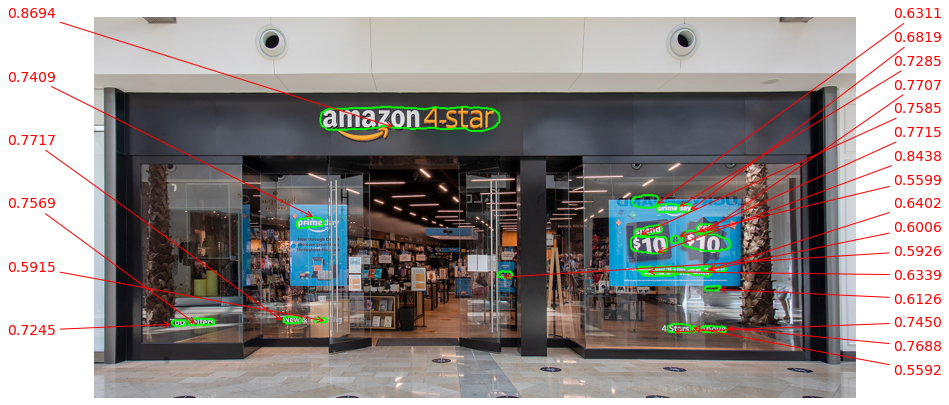

In [13]:
batch_boxes, batch_scores = dbnet.predict(
    batch_images = tf.expand_dims(image, 0), 
    batch_true_sizes = [raw_image.shape[:2]], 
    output_polygon = True
)
draw_predictions(raw_image, batch_boxes[0], batch_scores[0])